In [1]:
from controller import *

from scipy import stats

Primeiramente, vamos carregar nosso DataFrame com as variáveis de interesse.

In [2]:
colunas = ['continent', 'location', 'total_cases_per_million', 'population_density']
df = load_df(colunas, continental = False)
df

,continent,location,total_cases_per_million,population_density
0,North America,Aruba,18.733,584.8
1,North America,Aruba,NaN,584.8
2,North America,Aruba,37.465,584.8
3,North America,Aruba,NaN,584.8
4,North America,Aruba,NaN,584.8
...,...,...,...,...
47323,NaN,International,NaN,NaN
47324,NaN,International,NaN,NaN
47325,NaN,International,NaN,NaN
47326,NaN,International,NaN,NaN


Agrupamos então por 'location' e o 'total_cases_per_million' será o máximo encontrado, isto é, o dado mais atualizado do banco.

In [3]:
df = df.groupby(['location']).max()

E então excluímos linhas com valores faltantes.

In [4]:
df = df.dropna()
df

,continent,total_cases_per_million,population_density
location,,,
Afghanistan,Asia,1008.725,54.422
Albania,Europe,4742.859,104.871
Algeria,Africa,1175.115,17.348
Andorra,Europe,26532.065,163.755
Angola,Africa,152.527,23.890
...,...,...,...
Venezuela,South America,2641.797,36.253
Vietnam,Asia,11.239,308.127
Yemen,Asia,68.229,53.508


ANÁLISE EXPLORATÓRIA

Para analisarmos inicialmente nossos dados de forma visual, vejamos a relação entre a Densidade Populacional e o número Total de Casos (por milhão). A escala logarítmica foi utilizada para facilitar a visualização da tendência dos pontos. 

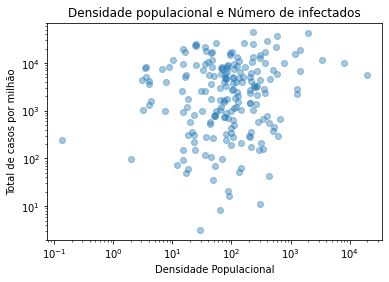

In [5]:
plt.scatter(df['population_density'], df['total_cases_per_million'], alpha = 0.4)
plt.xlabel('Densidade Populacional')
plt.ylabel('Total de casos por milhão')
plt.title("Densidade populacional e Número de infectados")

plt.xscale("log")
plt.yscale("log")

plt.show()

Intuitivamente, pensamos que quanto maior a Densidade, maior seria o número de Casos. Porém, com o gráfico, isso não parece ser uma regra, pois os dados não parecem estar correlacionados. Vejamos abaixo então qual é o valor da Correlação de Pearson para essas duas variáveis.

In [6]:
densidadeXcasos = df[['population_density','total_cases_per_million']]
print(densidadeXcasos.corr(method='pearson').values[0][1])

0.07111278868729347


Assim, vemos que, de fato, a correlação é bem baixa. Logo, definimos a Hipótese Nula: "A densidade populacional não influencia no número de infectados". Vamos tentar rejeitá-la nos passos que se seguem.

TESTE DE HIPÓTESE E INTERVALO DE CONFIANÇA

Primeiro realizamos um Teste de Permutação sobre os dados para n=5000 amostras. Definimos como Alta Densidade as densidades maiores do que 200. 

In [7]:
media_alta_densidade = df[df['population_density'] > 200]['total_cases_per_million'].mean()
print("A média real de número de Casos (por milhão) para populações com Densidade > 200 é: ", media_alta_densidade)

shuffle_df = df.copy()
n_amostras = 5000
amostras = np.zeros(n_amostras)

for i in range(n_amostras):
    np.random.shuffle(shuffle_df['population_density'])
    amostra = shuffle_df[shuffle_df['population_density'] > 200]
    amostras[i] = amostra['total_cases_per_million'].mean()

A média real de número de Casos (por milhão) para populações com Densidade > 200 é:  7594.932827586208


<ipython-input-7-14cf4d7edc58>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np.random.shuffle(shuffle_df['population_density'])


Agora plotaremos o histograma das médias dos números Totais de Casos encontrados para as amostras (com densidades altas).

O intervalo de confiança é: ( 4023.3260135187593 , 7352.816336432967 )


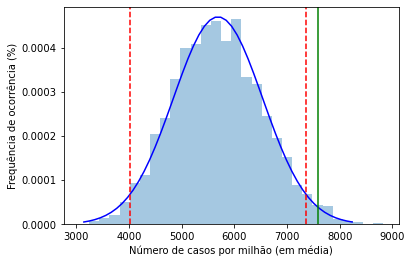

In [8]:
import scipy.stats as stats

media = amostras.mean()
desvio = np.std(amostras, ddof = 1)

x = np.linspace(media - 3*desvio, media + 3*desvio)

ic = stats.norm.interval(0.95, loc=media, scale=desvio)
print("O intervalo de confiança é: (",ic[0],",",ic[1],")")

norm = stats.norm.pdf(x, media, desvio)

plt.hist(amostras, bins=30, density = True, alpha=0.4)
plt.plot(x, norm, color='blue')

plt.axvline(media_alta_densidade, ymin=0, ymax=1, color='green')
plt.axvline(ic[0], ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(ic[1], ymin=0, ymax=1, color='red', linestyle='--')

plt.xlabel('Número de casos por milhão (em média)')
plt.ylabel('Frequência de ocorrência (%)')
plt.show()

Além disso, plotamos sobre o histograma a curva de distribuição normal que se ajusta aos dados. O intervalo de confiança são as linhas tracejadas em vermelho e a linha vertical em verde é a média real do número Total de Casos (por milhão) para populações de Alta Densidade (isto é, maiores que 200). Com esses resultados, vemos que essa média real está fora do intervalo de confiança. Dessa forma, rejeitamos nossa hipótese nula. Isso é um indicativo que, de fato, como pensamos intuitivamente, a Densidade Populacional exerce sim influência sobre o Total de Infectados pela Covid-19 (mesmo que outros fatores, dos quais não temos conhecimento, influencie esses resultados). Sendo assim, plotamos abaixo algumas variáveis que, talvez, sejam responsáveis pela baixa correlação entre a Densidade e o número de Casos.

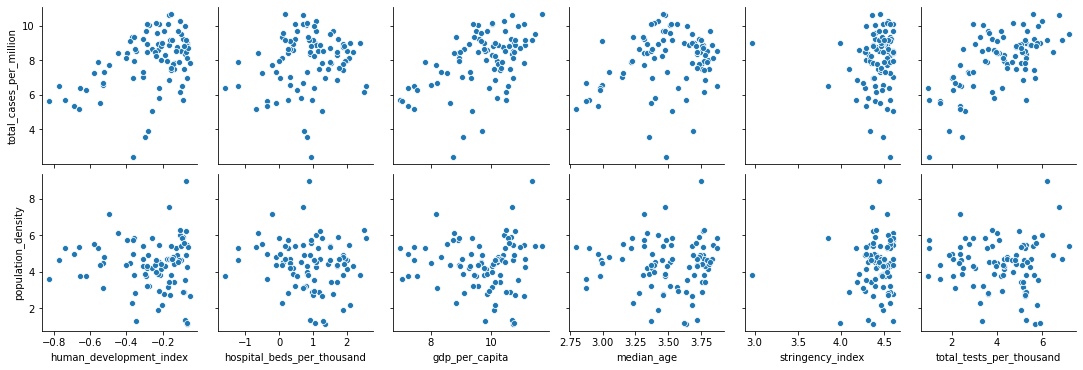

In [9]:
from seaborn import pairplot

colunas2 = ['continent', 'location', 'total_cases_per_million', 'population_density', 'human_development_index', 
           'hospital_beds_per_thousand', 'gdp_per_capita', 'median_age', 'stringency_index', 'total_tests_per_thousand']
df2 = load_df(colunas2, continental = False)

df2 = df2.groupby(['location']).max()
df2 = df2.dropna()

df2[['total_cases_per_million', 'population_density', 'human_development_index', 
      'hospital_beds_per_thousand', 'gdp_per_capita', 'median_age', 'stringency_index', 'total_tests_per_thousand']] = np.log(df2[['total_cases_per_million', 'population_density', 'human_development_index', 
      'hospital_beds_per_thousand', 'gdp_per_capita', 'median_age', 'stringency_index', 'total_tests_per_thousand']])

pairplot(df2, y_vars=['total_cases_per_million', 'population_density'], x_vars=['human_development_index', 
      'hospital_beds_per_thousand', 'gdp_per_capita', 'median_age', 'stringency_index', 'total_tests_per_thousand'])

plt.show()

Visualmente inferimos que há uma provável forte relação, por exemplo, entre o Total de Casos e o Índice de Desenvolvimento Humano ou o GDP/PIB per capita, a Idade Média da população ou o número Total de Testes (por mil).